In [1]:
import numpy as np
import pandas as pd
import importlib
import data_loader
import gibbs_sampler
importlib.reload(data_loader)
importlib.reload(gibbs_sampler)
from data_loader import CountryDataLoader
from scipy.sparse import block_diag as sparse_block_diag

In [2]:
file_path = r'D:\Bachelor Data\Train'

loader = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,  # or None for all
    mode="train"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]

loader.load_data(split_date="19351231")  # or 
pre_data = loader.pretrain_dict
train_data = loader.train_dict

X_dict_pre = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader.pretrain_dict.items()
}

Y_dict_pre = {
    c: df["y"].to_numpy()
    for c, df in loader.pretrain_dict.items()
}

X_pre = np.vstack([X_dict_pre[c] for c in X_dict_pre])
Y_pre = np.concatenate([Y_dict_pre[c] for c in Y_dict_pre])
Z_pre = sparse_block_diag([X_dict_pre[c] for c in X_dict_pre]).tocsr()


# --- Train data ---
X_dict = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader.train_dict.items()
}

Y_dict = {
    c: df["y"].to_numpy()
    for c, df in loader.train_dict.items()
}

X = np.vstack([X_dict[c] for c in X_dict])
Y = np.concatenate([Y_dict[c] for c in Y_dict])
Z = sparse_block_diag([X_dict[c] for c in X_dict]).tocsr()



In [3]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1e-1,fit_intercept=False)  
ridge.fit(X_pre, Y_pre)

theta_g_ridge = ridge.coef_
residuals = Y_pre - X_pre @ theta_g_ridge

In [ ]:

tau_theta_g_sq = 9e-6

resid_prec = 10000000
alpha_sigma = resid_prec
beta_sigma = 1
# Λ_c ~ Gamma(α, β) prior: set α * β = τ²

alpha_lambda = 300
beta_lambda = 5

# Wishart prior: mean(diag(Sigma)) = τ²
Sigma = tau_theta_g_sq * np.eye(X_pre.shape[1])
nu = X_pre.shape[1] + 10
# 

n_iter = 20000
burn_in = 10000


In [7]:
resid_prec

np.float64(30.69225350234201)

In [5]:
tau_theta_g_sq

9e-06

In [9]:
import gibbs_sampler
importlib.reload(gibbs_sampler)
from gibbs_sampler import HierarchicalGibbsSampler

sampler = HierarchicalGibbsSampler(
    X_dict=X_dict,
    Y_dict=Y_dict,
    X=X,
    Y=Y,
    Z=Z,
    n_iter=n_iter,
    burn_in=burn_in,
    tau_theta_g_sq=tau_theta_g_sq,
    alpha_sigma=alpha_sigma,
    beta_sigma=beta_sigma,
    hyper_type="gamma",  # or "gamma"
    alpha_lambda=alpha_lambda,
    beta_lambda=beta_lambda,
    Sigma=Sigma,
    nu=nu
)

sampler.run()

  0%|          | 1/20000 [00:01<6:35:00,  1.19s/it]

0.011022381224913572


  0%|          | 2/20000 [00:02<6:35:31,  1.19s/it]

0.0038040201090592373


  0%|          | 3/20000 [00:03<6:34:55,  1.18s/it]

0.003802729269348685


  0%|          | 4/20000 [00:04<6:39:38,  1.20s/it]

0.0037981452664167287


  0%|          | 5/20000 [00:05<6:39:15,  1.20s/it]

0.0038018861357232937


  0%|          | 6/20000 [00:07<6:39:23,  1.20s/it]

0.003802620564650997


  0%|          | 7/20000 [00:08<6:37:12,  1.19s/it]

0.003800041631987518


  0%|          | 8/20000 [00:09<6:38:04,  1.19s/it]

0.0038018651636477817


  0%|          | 9/20000 [00:10<6:37:31,  1.19s/it]

0.003800585063989359


  0%|          | 10/20000 [00:11<6:36:03,  1.19s/it]

0.003801033651612346


  0%|          | 10/20000 [00:12<7:03:34,  1.27s/it]


KeyboardInterrupt: 

In [22]:
import importlib
import gibbs_sampler
importlib.reload(gibbs_sampler)
from gibbs_sampler import PosteriorAnalyzer

post_analyzer = PosteriorAnalyzer(
    theta_g_path="theta_g_samples.parquet",
    theta_l_path="theta_l_samples.parquet",
    gc_path="Gc_samples.parquet",
    burn_in=0
)

theta_g_samples = post_analyzer.get_theta_g_samples()
theta_l_samples = post_analyzer.get_theta_l_samples("swe")

theta_g_median = post_analyzer.get_theta_g_median()

In [ ]:
theta_l_samples.var()

In [10]:
theta_g_samples.var()

np.float64(8.362518484851824e-06)

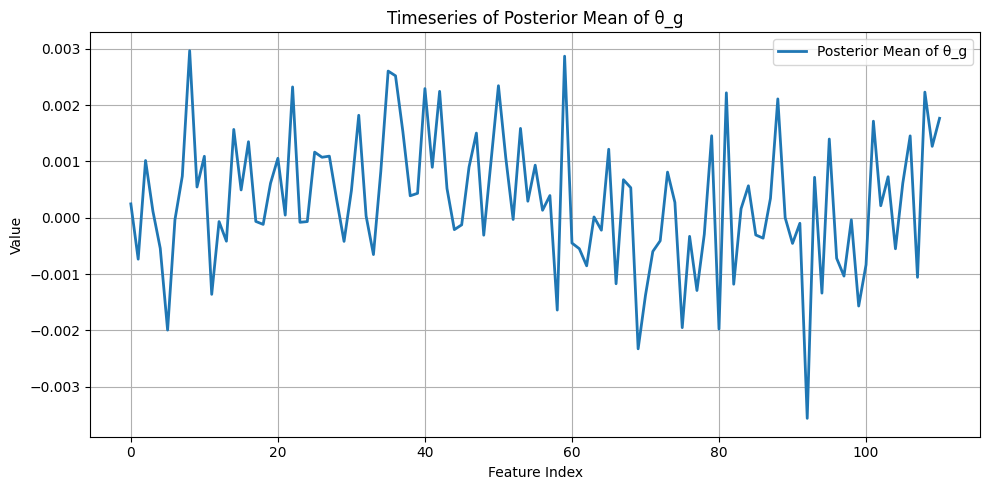

In [18]:
post_analyzer.plot_timeseries_median("theta_g")

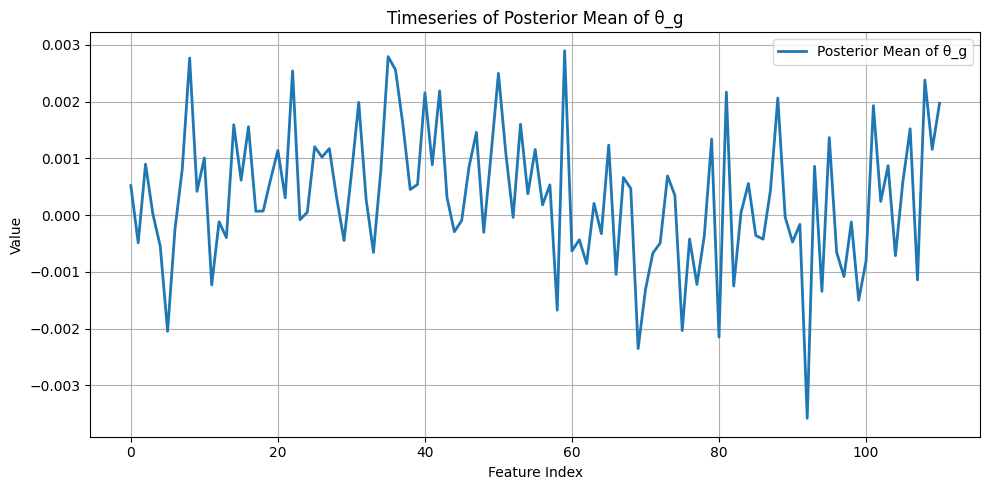

In [19]:
post_analyzer.plot_timeseries_mean("theta_g")

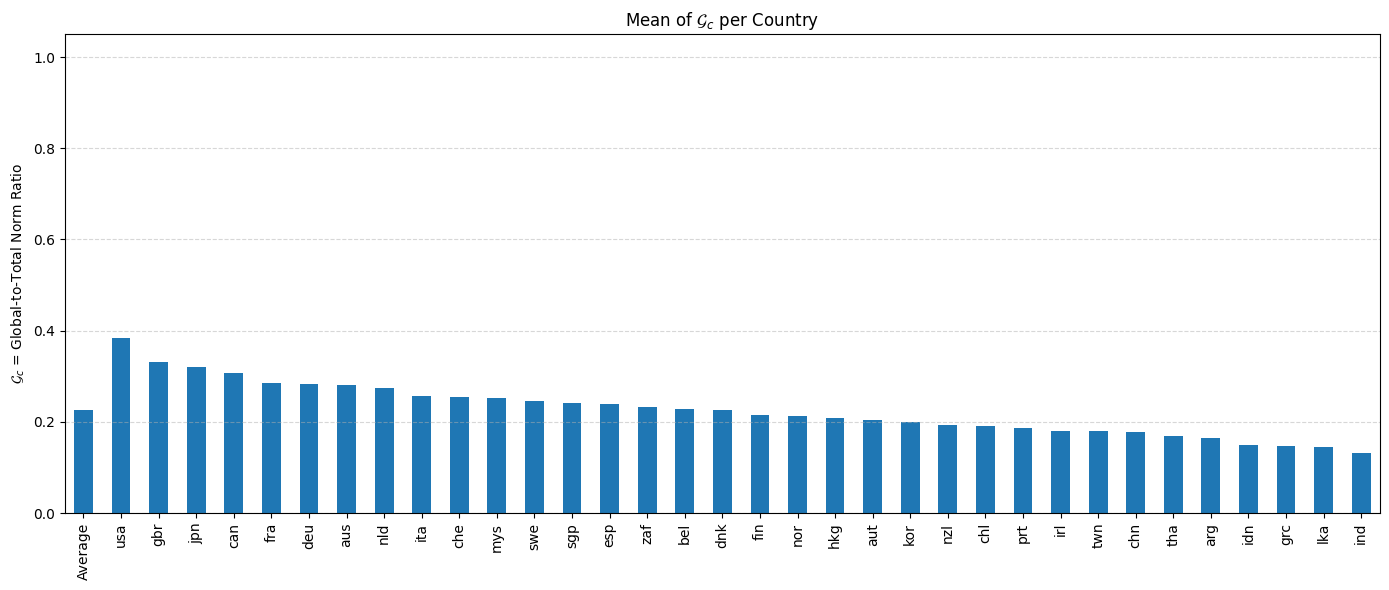

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get Gc means
Gc_mean = post_analyzer.get_Gc_posterior_mean()
Gc_mean["Average"] = np.mean([v for k, v in Gc_mean.items() if k != "Average"])

# Reorder: put 'Average' first, then the rest sorted descending
sorted_keys = ["Average"] + sorted([k for k in Gc_mean if k != "Average"], key=lambda x: Gc_mean[x], reverse=True)
Gc_mean_ordered = pd.Series({k: Gc_mean[k] for k in sorted_keys})

# Plot
Gc_mean_ordered.plot(kind="bar", figsize=(14, 6))
plt.title("Mean of $\\mathcal{G}_c$ per Country")
plt.ylabel("$\\mathcal{G}_c$ = Global-to-Total Norm Ratio")
plt.ylim(0, 1.05)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




In [6]:
from data_loader import CountryDataLoader
file_path = 'D:/Bachelor Data/Test'

loader_predict = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=None,  # or None for all
    mode="test"
)
features_to_drop = ["eom", "gvkey", "y", "weight","ret_exc_lead1m"]

loader_predict.load_data(split_date=None)

X_test = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader_predict.data_dict.items()
}

Y_test = {
    c: df["y"].to_numpy()
    for c, df in loader_predict.data_dict.items()
}


In [ ]:
from sklearn.metrics import r2_score
import numpy as np

theta_g = post_analyzer.get_theta_g_mean()
theta_l = post_analyzer.get_theta_l_mean()

y_true_all = []
y_pred_all = []

for c in X_test:
    X_c = X_test[c]
    y_c = Y_test[c]

    if c not in theta_l:
        continue  # skip countries not in training set

    theta_total = theta_g + theta_l[c]
    y_pred = X_c @ theta_total

    y_true_all.append(y_c)
    y_pred_all.append(y_pred)

y_true = np.concatenate(y_true_all)
y_pred = np.concatenate(y_pred_all)

print("$R^2" ,r2_score(y_true,y_pred)*100,"%")

$R^2 -1.6482488649260274 %


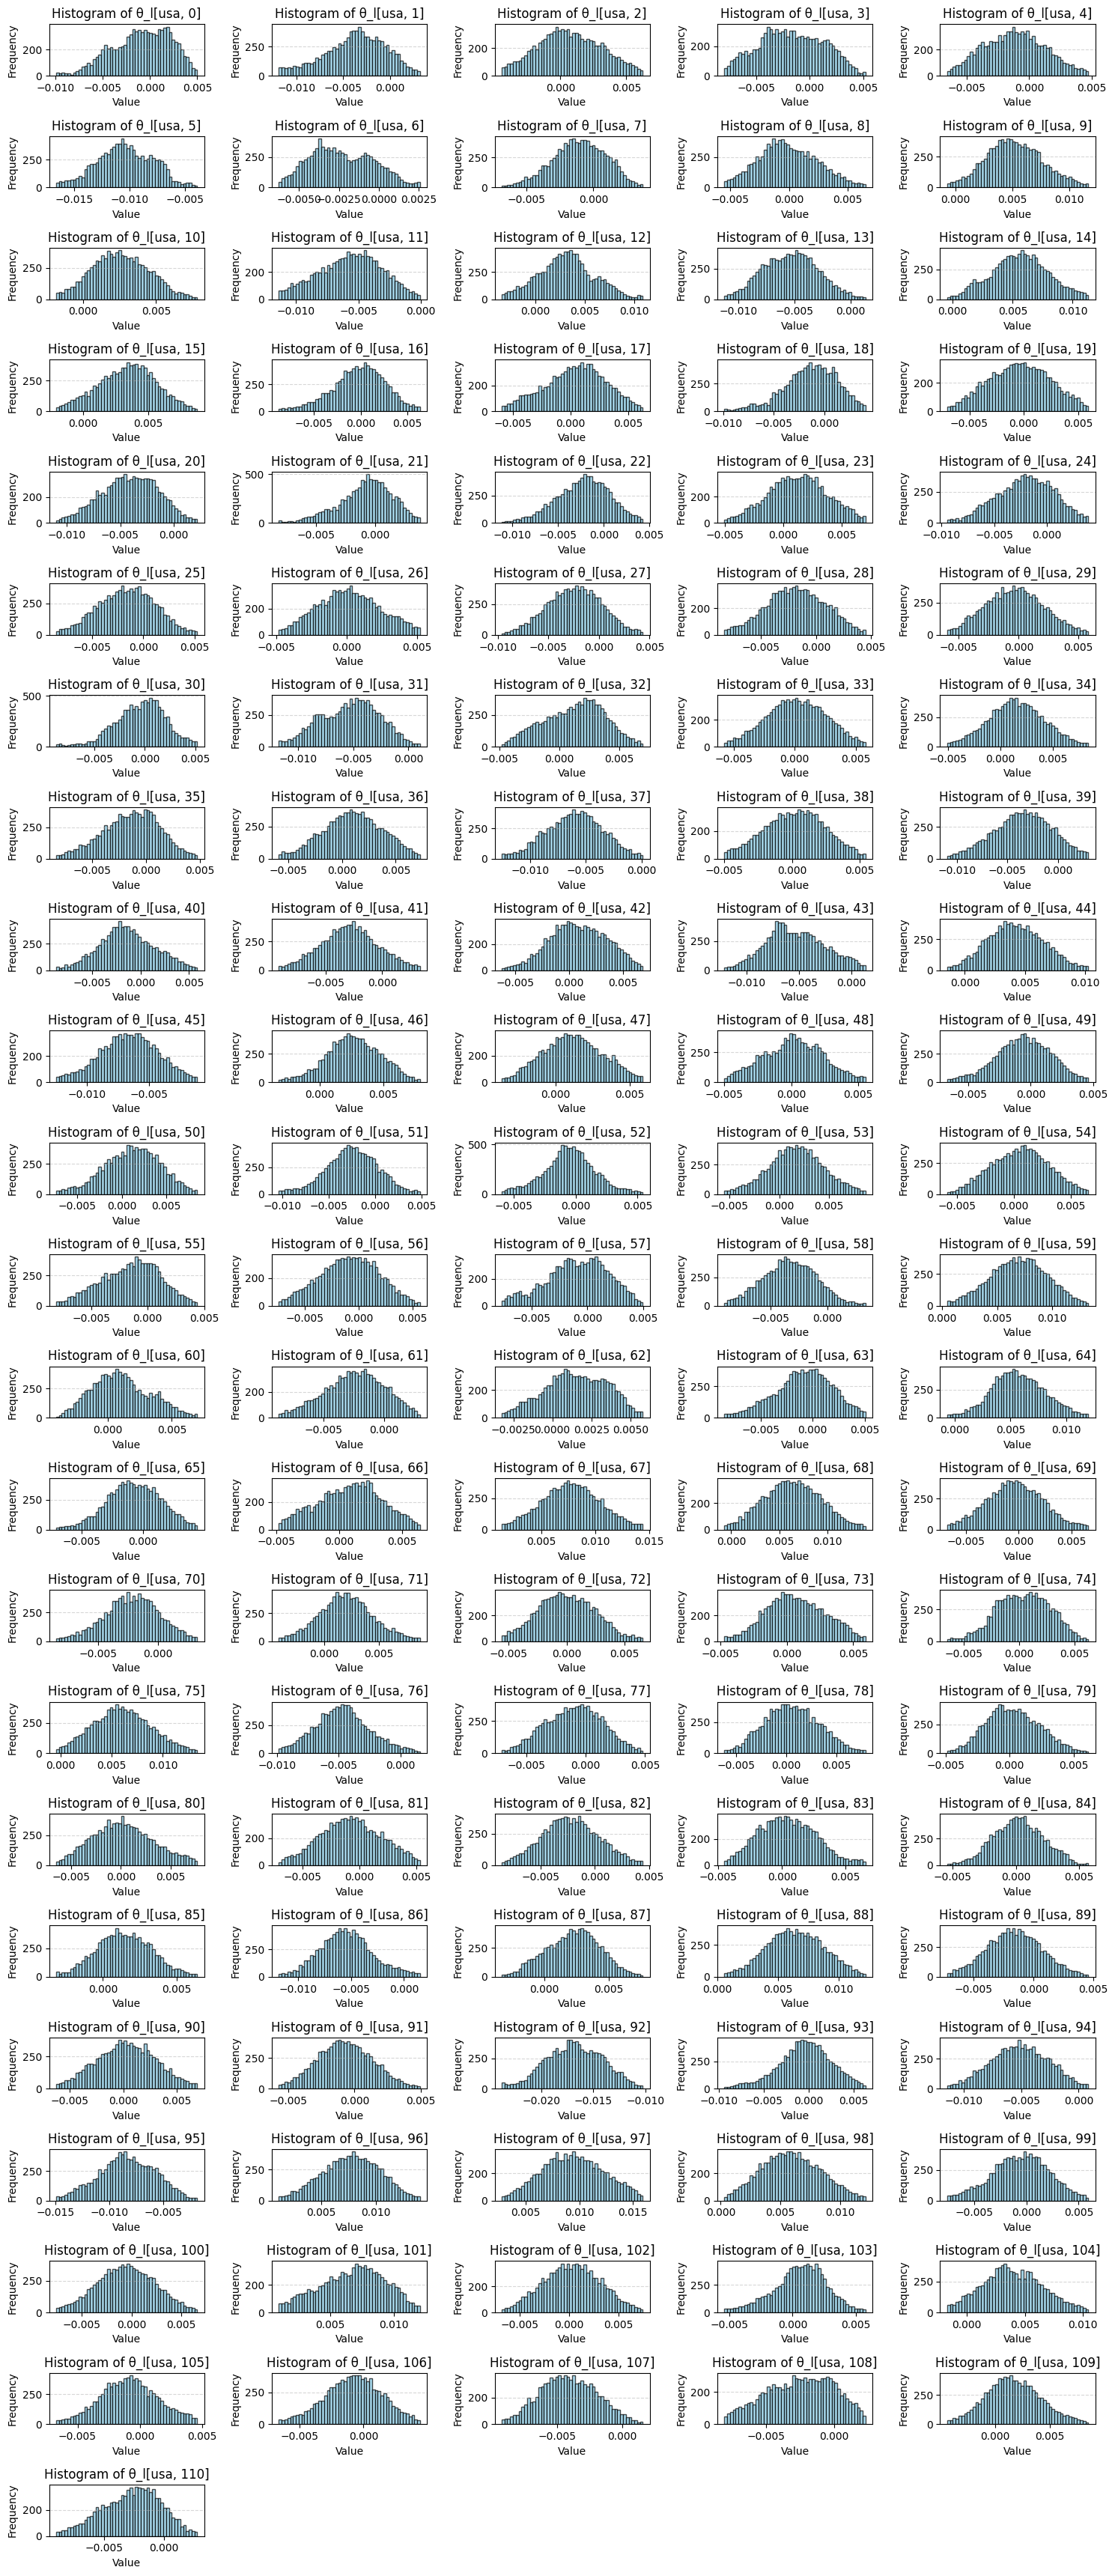

In [23]:
import matplotlib.pyplot as plt

# Total number of plots
n_plots = 111
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 1.5))  # Adjust size as needed

for i in range(n_plots):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    post_analyzer.plot_histogram("theta_l", i,"usa",ax=ax)  # Make sure your plot_histogram can take ax

# Hide any unused axes
for i in range(n_plots, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

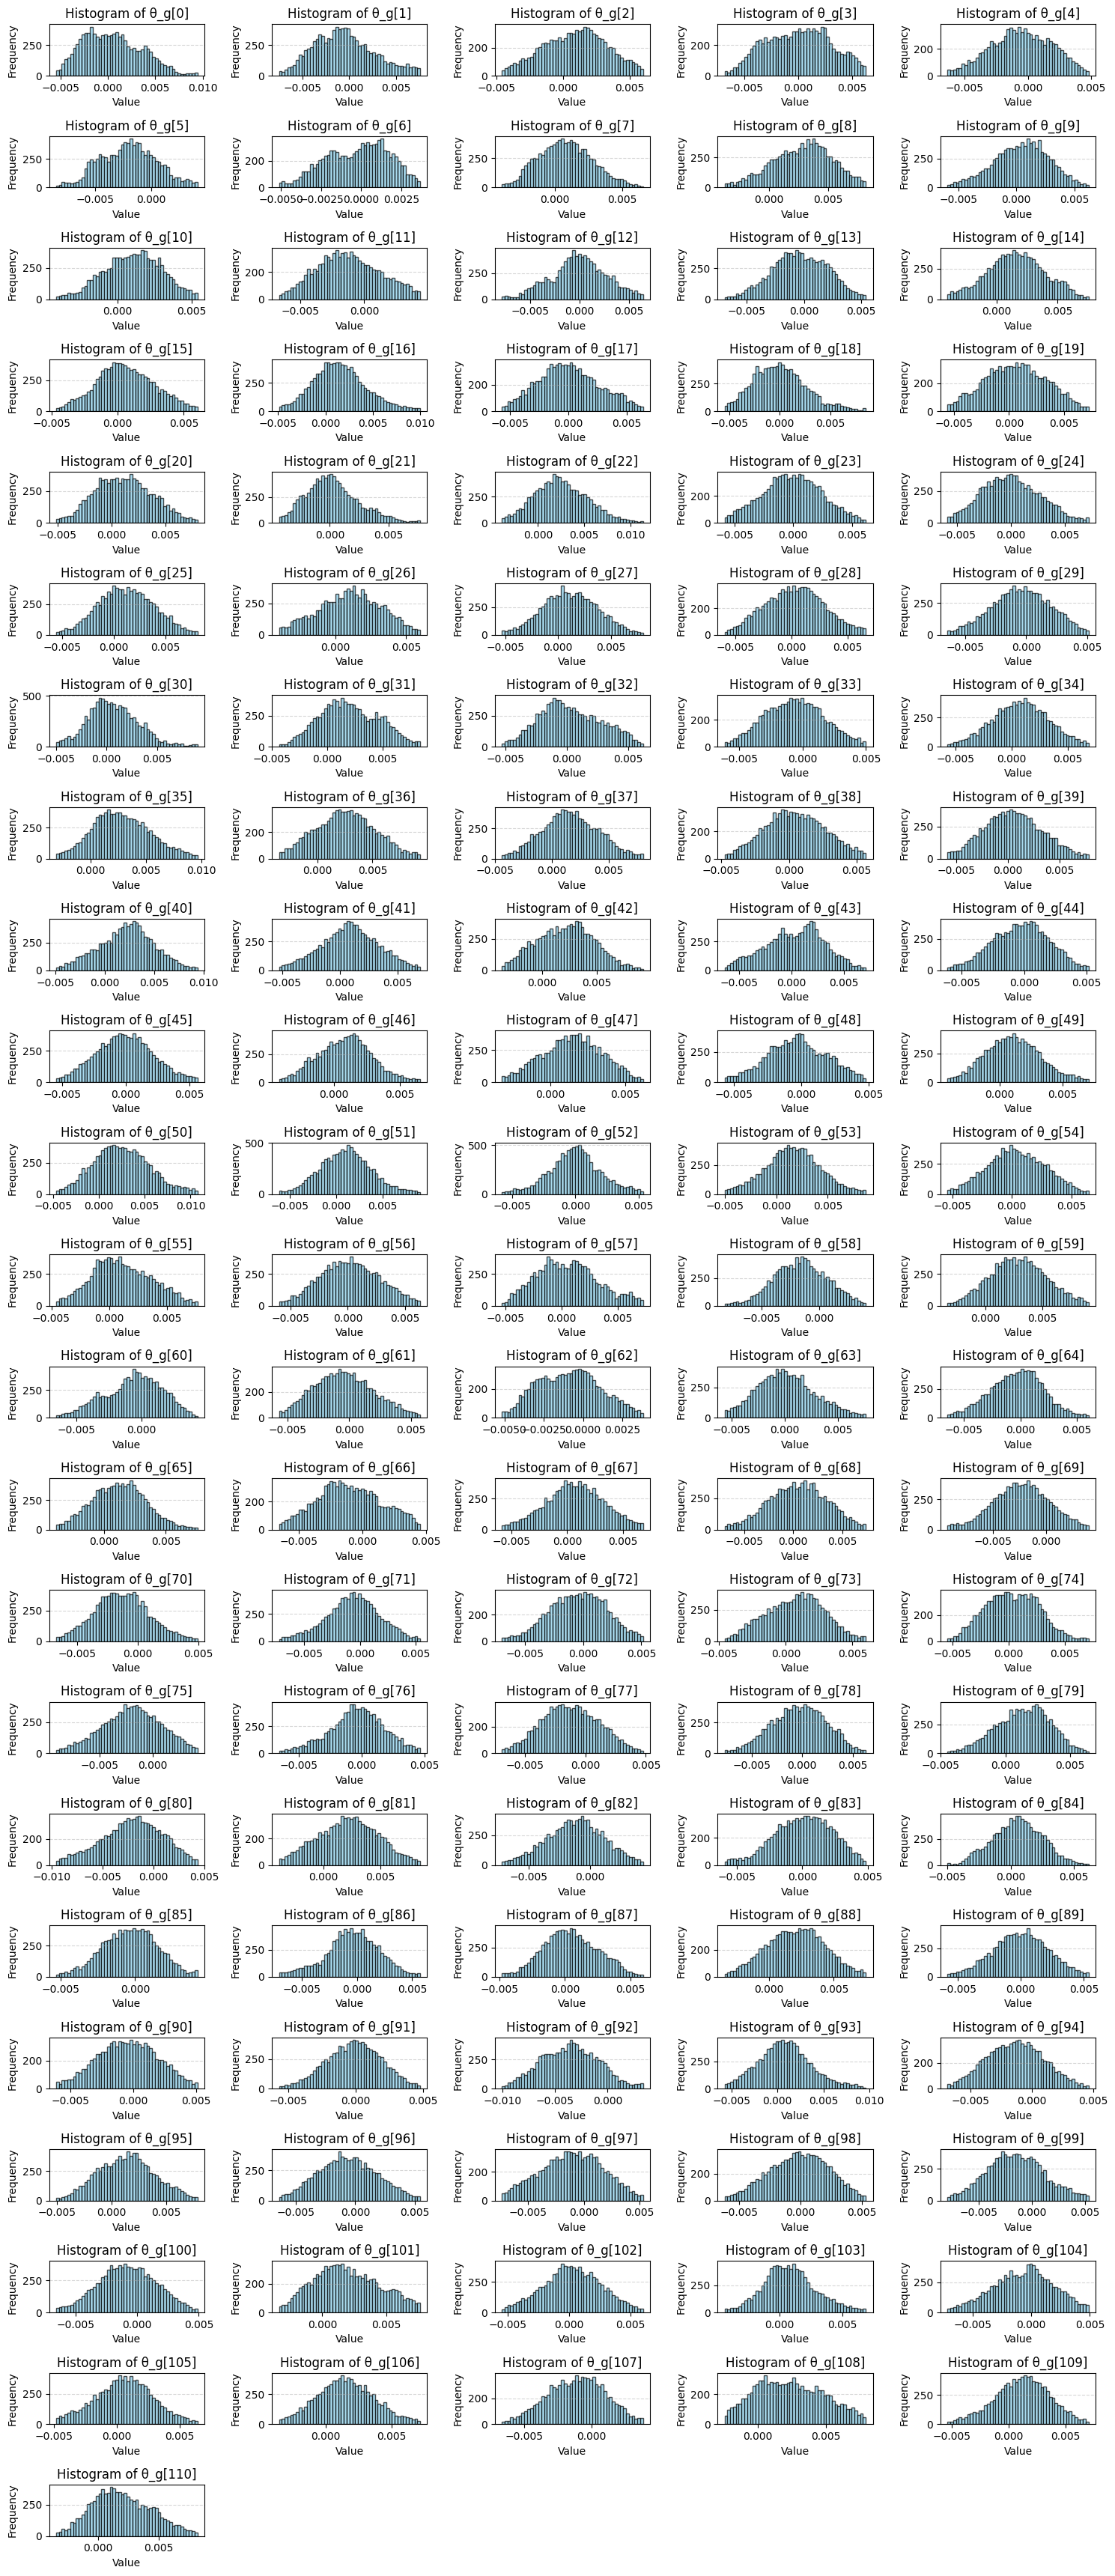

In [24]:
import matplotlib.pyplot as plt

# Total number of plots
n_plots = 111
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 1.5))  # Adjust size as needed

for i in range(n_plots):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    post_analyzer.plot_histogram("theta_g", i, ax=ax)  # Make sure your plot_histogram can take ax

# Hide any unused axes
for i in range(n_plots, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()